In [16]:
import h5py
from tqdm import tqdm
import imageio
import io

import torch
import numpy as np
import pytorch_lightning as pl
from torchmetrics import MeanSquaredError
from scipy.stats import binned_statistic

from hpl.datamodule.DataLoader import L96InferenceDataset
from hpl.datamodule.observational_models import RandomObservationModel
from mdml_tools.simulators.lorenz96 import L96Simulator

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 13
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Set random seed for reproducibility
pl.seed_everything(1000)
# choose device. GPU is default if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Global seed set to 1000


In [4]:
# path to training and test data
train_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/training/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
# path to assimilation network checkpoint
pretrained_network_checkpoint = "/gpfs/work/zinchenk/final_experiments/140424_imperfect_forward_operator/pretrain_data_assimilation/multirun/2024-03-14/03-19-59/0/logs/checkpoints/assimilation_network.ckpt"
trained_network_checkpoint = "/gpfs/work/zinchenk/final_experiments/300424_parametrization_learning/parametrization_learning/multirun/2024-04-30/13-17-52/0/logs/checkpoints/assimilation_network.ckpt"
# path to simulator checkpoint with coupled parametrization
simulator_checkpoint = "/gpfs/work/zinchenk/final_experiments/300424_parametrization_learning/parametrization_learning/multirun/2024-04-30/13-17-52/0/logs/checkpoints/simulator.ckpt"

In [5]:
train_data = {}
with h5py.File(train_data_path, "r") as file:
    train_data["first_level"] = torch.tensor(file["first_level"][:][0], device=device, requires_grad=False)
    train_data["second_level"] = torch.tensor(file["second_level"][:][0], device=device, requires_grad=False)

In [6]:
test_data = {}
with h5py.File(test_data_path, "r") as file:
    test_data["first_level"] = torch.tensor(file["first_level"][:], device=device, requires_grad=False)
    test_data["second_level"] = torch.tensor(file["second_level"][:], device=device, requires_grad=False)

In [7]:
# pretrained_network = torch.load(pretrained_network_checkpoint, map_location=device)
trained_network = torch.load(trained_network_checkpoint, map_location=device)
parametrized_simulator = torch.load(simulator_checkpoint, map_location=device)

# Input-output function

In [8]:
h, c, b = 10, 1, 10
k, j = 36, 10

correction_term = []
for i in range(train_data["second_level"].size(0)):
    y_mean = train_data["second_level"][i].reshape((k, j)).mean(dim=-1)
    term = -h * c * y_mean
    correction_term.append(term)
correction_term = torch.stack(correction_term)

In [9]:
y_plot = correction_term.flatten().cpu().numpy()
x_plot = train_data["first_level"].flatten().cpu().numpy()

mean, bin_edges, _ = binned_statistic(x_plot, y_plot, bins=15)
std, _, _ = binned_statistic(x_plot, y_plot, bins=15, statistic="std")
count, _, _ = binned_statistic(x_plot, y_plot, bins=15, statistic="count")

bin_centers = np.convolve(bin_edges, np.ones(2)/2, mode='valid')
sem = std / np.sqrt(count)

In [10]:
parametrization = parametrized_simulator.parametrization
x_in = torch.tensor(bin_centers).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.no_grad():
    b_out = parametrization.forward(x_in)

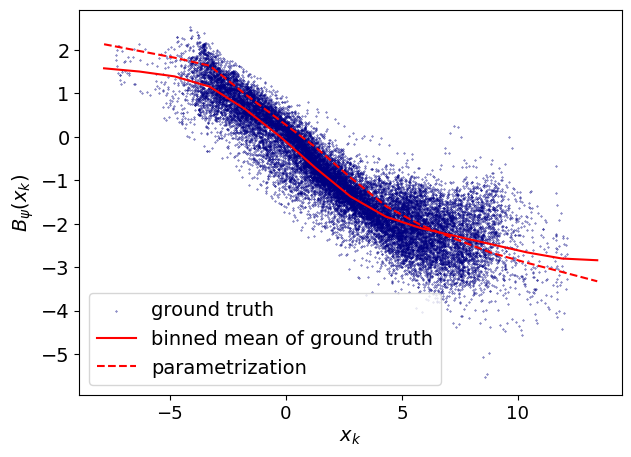

In [11]:
n_points = 20000
fig = plt.figure(figsize=(7, 5), facecolor="white")
plt.scatter(
    x_plot[:n_points], 
    y_plot[:n_points], 
    s=0.1, label="ground truth", color="navy")
plt.plot(bin_centers, mean, color="red", label="binned mean of ground truth")
plt.plot(x_in.squeeze().detach().to("cpu").numpy(), b_out.squeeze().detach().to("cpu").numpy(), color="red", ls="--", label="parametrization")


plt.yticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r"$x_k$", fontsize=14)
plt.ylabel(r"$B_{\psi}(x_k)$", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("input_output_function.png", dpi=300)

# Data assimilation and forecast example

In [19]:
pretrained_network_checkpoint = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/tmp/outputs/pretrain_data_assimilation/outputs/2024-01-08/12-47-44/logs/checkpoints/assimilation_network.ckpt"
trained_network_checkpoint = "/gpfs/work/zinchenk/hpl_logs/parametrization_learning/multirun/2024-01-08/20-06-13/0/logs/checkpoints/assimilation_network.ckpt"

In [21]:
pretrained_network = torch.load(pretrained_network_checkpoint, map_location=device)
trained_network = torch.load(trained_network_checkpoint, map_location=device)
ground_truth = test_data["first_level"]

In [22]:
# instantiate observational model
observational_model = RandomObservationModel(
    additional_noise_std=1.0,
    random_mask_fraction=0.75,
)

# instantiate dataset
loader = L96InferenceDataset(
    ground_truth_data=ground_truth.to("cpu"),
    observation_model=observational_model,
    input_window_extend=25,
    drop_edge_samples=True,
)
loader.to(device)

In [23]:
reconstruction = {"no_param": [], "param": []}

for batch in tqdm(loader):
    with torch.no_grad():
        state = pretrained_network.forward(batch)
        reconstruction["no_param"].append(state)
        state = trained_network.forward(batch)
        reconstruction["param"].append(state)

reconstruction["no_param"] = torch.concat(reconstruction["no_param"], dim=1)
reconstruction["param"] = torch.concat(reconstruction["param"], dim=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 951/951 [00:40<00:00, 23.34it/s]


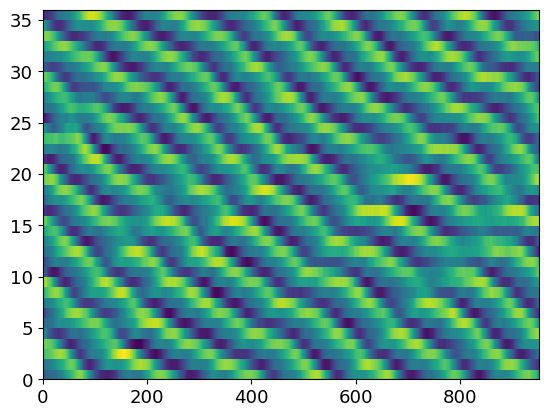

In [24]:
plt.pcolor(reconstruction["no_param"].to("cpu")[10].T)

In [25]:
ground_truth = loader.ground_truth.to("cpu")
observations = loader.observations.to("cpu")
mask = observations == 0
observations = torch.masked_fill(observations, mask, np.nan)

In [26]:
reconstructions_param = torch.full_like(ground_truth, fill_value=np.nan)
reconstructions_param[:, 25:-24] = reconstruction["param"]

reconstructions_no_param = torch.full_like(ground_truth, fill_value=np.nan)
reconstructions_no_param[:, 25:-24] = reconstruction["no_param"]

In [27]:
index = 10

gt_plot = ground_truth[index, :300]


obs_plot = torch.full_like(gt_plot, fill_value=np.nan)
obs_plot[:300] = observations[index, :300]
recp_plot = reconstructions_param[index, :300]
recnp_plot = reconstructions_no_param[index, :300]

forecast_time = torch.arange(0, 0.01*200, 0.01)
icp = recp_plot[-1].unsqueeze(0).unsqueeze(0).to("cuda")
icnp = recnp_plot[-1].unsqueeze(0).unsqueeze(0).to("cuda")

with torch.no_grad():
    forecast_p = parametrized_simulator.integrate(forecast_time, icp).squeeze().cpu()
    forecast_np = parametrized_simulator.integrate(forecast_time, icnp).squeeze().cpu()

parametrized = torch.cat([recp_plot, forecast_p], dim=0)
not_parametrized = torch.cat([recnp_plot, forecast_np], dim=0)

/gpfs/work/zinchenk/lib/miniconda3/envs/hpl-torch/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


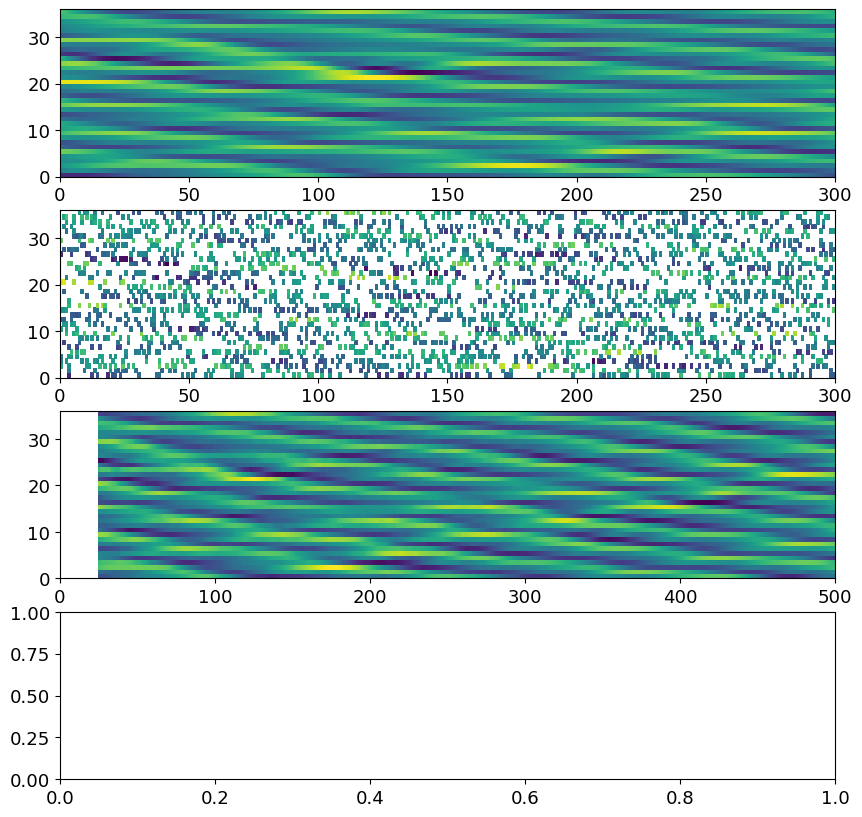

In [28]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

axes[0].pcolor(gt_plot.T)
axes[1].pcolor(obs_plot.T)
axes[2].pcolor(parametrized.T)

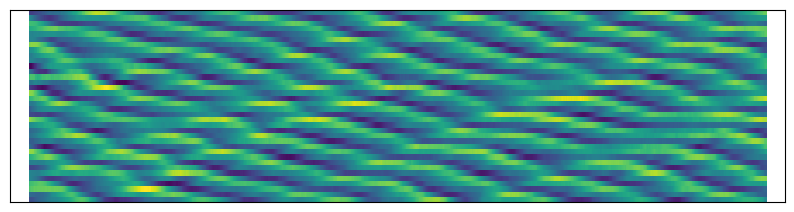

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5), facecolor="white")

# ax.pcolor(ground_truth[index].T)
# ax.pcolor(observations[index].T)
ax.pcolor(reconstructions_param[index].T)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("reconstruction.png", dpi=300, bbox_inches='tight')

In [30]:
rmse_func = MeanSquaredError(False)
true = ground_truth[index]
pred = reconstructions_param[index]
rmse_plot = torch.full((len(true), ), fill_value=np.nan)
for i in range(len(true)):
    rmse_value = rmse_func(pred[i], true[i])
    rmse_plot[i] = rmse_value


In [31]:
rmse_plot

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.4908, 0.4791,
        0.4734, 0.4683, 0.4860, 0.4992, 0.5404, 0.5534, 0.6440, 0.6800, 0.7262,
        0.7643, 0.7642, 0.7616, 0.7451, 0.7210, 0.7174, 0.6832, 0.6812, 0.6452,
        0.6269, 0.6352, 0.5752, 0.5873, 0.6098, 0.6417, 0.6433, 0.6442, 0.6549,
        0.6899, 0.6325, 0.6289, 0.6062, 0.5983, 0.5783, 0.5727, 0.5692, 0.5636,
        0.5694, 0.5678, 0.5327, 0.4932, 0.4493, 0.4395, 0.4482, 0.4426, 0.4611,
        0.4605, 0.4708, 0.4625, 0.4792, 0.4755, 0.4764, 0.4819, 0.4795, 0.5085,
        0.5243, 0.5731, 0.5658, 0.5740, 0.6116, 0.6187, 0.6032, 0.5996, 0.6040,
        0.6035, 0.5815, 0.5779, 0.6099, 0.6085, 0.5941, 0.6104, 0.5968, 0.6153,
        0.5823, 0.6006, 0.6225, 0.6562, 0.6801, 0.6682, 0.6697, 0.6536, 0.6679,
        0.6600, 0.6772, 0.6733, 0.6919, 

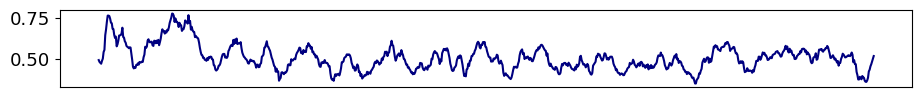

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(11, 1), facecolor="white")

ax.plot(rmse_plot, color="navy")
ax.set_xticks([])
fig.savefig("rmse.png", dpi=300, bbox_inches='tight')

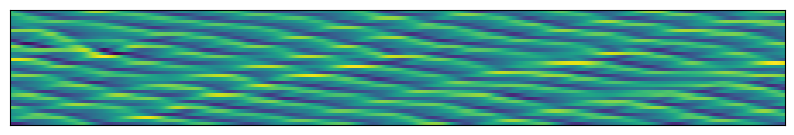

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 1.5), facecolor="white")

ax.pcolor(ground_truth[index].T)
# ax.pcolor(observations[index].T)
# ax.pcolor(ground_truth[index, 250:750].T)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("ground_truth.png", dpi=300, bbox_inches='tight')

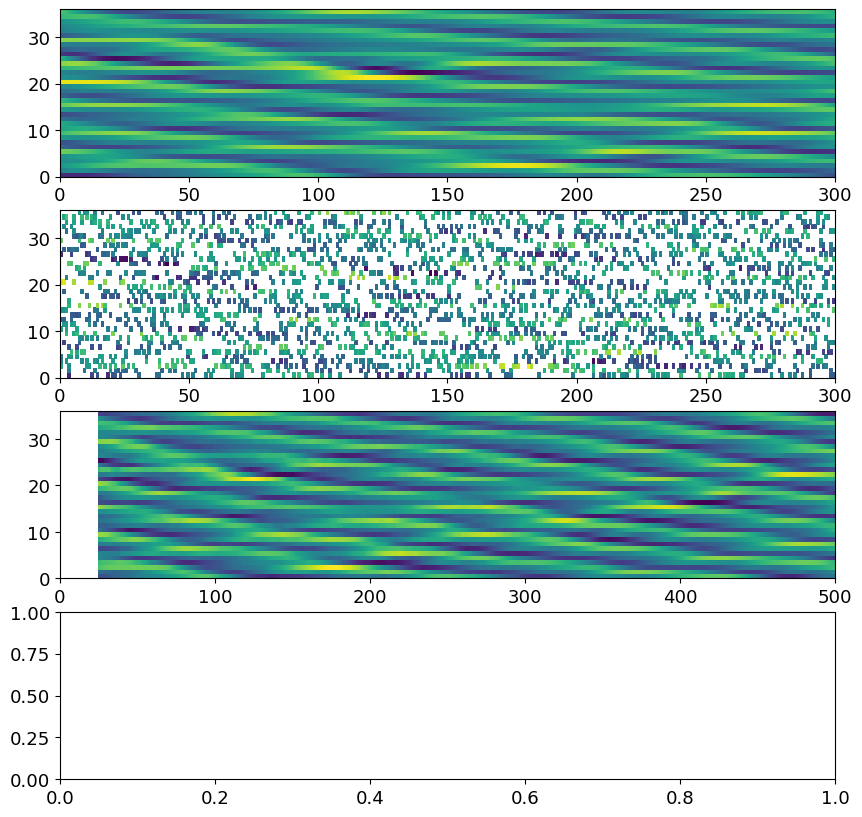

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

axes[0].pcolor(gt_plot.T)
axes[1].pcolor(obs_plot.T)
axes[2].pcolor(parametrized.T)

In [35]:
path_to_data = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
pretrained_network_checkpoint = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/tmp/outputs/pretrain_data_assimilation/outputs/2024-01-08/12-47-44/logs/checkpoints/assimilation_network.ckpt"
trained_network_checkpoint = "/gpfs/work/zinchenk/hpl_logs/parametrization_learning/multirun/2024-01-08/20-06-13/0/logs/checkpoints/assimilation_network.ckpt"

In [36]:
with h5py.File(path_to_data, "r") as file:
    first_level = torch.tensor(file["first_level"][:])

In [37]:
# Set random seed for reproducibility
pl.seed_everything(1000)

Global seed set to 1000


1000

In [60]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pretrained_network = torch.load(pretrained_network_checkpoint, map_location=device)
trained_network = torch.load(trained_network_checkpoint, map_location=device)

In [ ]:
loader = L96InferenceDataset(
    ground_truth_data=first_level[:, :300],
    additional_noise_std=1.0,
    mask_fraction=0.75,
    mask_fill_value=0.0,
    input_window_extend=25,
    extend_channels=True,
    drop_edge_samples=True,
)
loader.to(device)

In [ ]:
rmse_func = MeanSquaredError(False).to(device)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

ground_truth = loader.ground_truth[0].to(device)
observations = loader.observations[0].to(device)
mask = observations == 0
observations = torch.masked_fill(observations, mask, np.nan)
reconstruction_1 = torch.full_like(observations, fill_value=np.nan).to(device)
reconstruction_2 = torch.full_like(observations, fill_value=np.nan).to(device)
rmse_1 = torch.full((observations.shape[0],), fill_value=np.nan)
rmse_2 = torch.full((observations.shape[0],), fill_value=np.nan)
sampling_indexes = loader.sampling_indexes

with imageio.get_writer("assimilation.gif", mode='I') as gif_writer:
    for index, batch in tqdm(enumerate(loader)):
        current_index = sampling_indexes[index] - 25
        with torch.no_grad():
            state_1 = pretrained_network.forward(batch[0].unsqueeze(0)).squeeze()
            state_2 = trained_network.forward(batch[0].unsqueeze(0)).squeeze()
        reconstruction_1[current_index] = state_1
        reconstruction_2[current_index] = state_2
        rmse_1[current_index] = rmse_func(ground_truth[current_index], state_1)
        rmse_2[current_index] = rmse_func(ground_truth[current_index], state_2)

        axes[0].pcolor(ground_truth.to("cpu").T)

        axes[1].pcolor(observations.to("cpu").T)
        axes[1].vlines(current_index-25, 0, 36, color="green", linewidth=2.5)
        axes[1].vlines(current_index+25, 0, 36, color="green", linewidth=2.5)

        axes[2].pcolor(reconstruction_1.to("cpu").T)
        axes[3].pcolor(reconstruction_2.to("cpu").T)

        axes[4].plot(rmse_1, label="pretrained")
        axes[4].plot(rmse_2, label="parametrized")
        axes[4].set_xlim(0, 300)
        axes[4].set_ylim(0, 1)
        axes[4].legend(loc="upper right")

        for ax in axes:
            ax.set_xticklabels(ax.get_xticks()*0.01)

        axes[0].set_yticks([])
        axes[1].set_yticks([])
        axes[2].set_yticks([])
        axes[3].set_yticks([])

        axes[0].set_ylabel("true")
        axes[1].set_ylabel("observations")
        axes[2].set_ylabel("reconstruction \npretrained")
        axes[3].set_ylabel("reconstruction \nparametrized")
        axes[4].set_ylabel("RMSE")

        buffer = io.BytesIO()
        fig.savefig(buffer, format='png')
        buffer.seek(0)
        gif_writer.append_data(imageio.v3.imread(buffer))
        buffer.close()
        for ax in axes:
            ax.clear()

In [ ]:
ground_truth = loader.ground_truth.to(device)
sampling_indexes = loader.sampling_indexes
rmse = torch.empty(2, loader[0].size(0), len(sampling_indexes))
mse_func = torch.nn.MSELoss(reduction="none").to(device)

for index, batch in tqdm(enumerate(loader)):
    current_index = sampling_indexes[index] - 25
    with torch.no_grad():
        state = pretrained_network.forward(batch).squeeze()
        rmse[0, :, index] = mse_func(state, ground_truth[:, current_index]).mean(axis=1).sqrt()
        state = trained_network.forward(batch).squeeze()
        rmse[1, :, index] = mse_func(state, ground_truth[:, current_index]).mean(axis=1).sqrt()

In [ ]:
mean_error = rmse[0].mean(axis=0)
std_error = rmse[0].std(axis=0)
plt.plot(mean_error)
plt.plot(mean_error + std_error)
plt.plot(mean_error - std_error)

In [ ]:
mean_error = rmse[1].mean(axis=0)
std_error = rmse[1].std(axis=0)
plt.plot(mean_error)
plt.plot(mean_error + std_error)
plt.plot(mean_error - std_error)

In [62]:
path_to_file = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/training/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
with h5py.File(path_to_file, 'r') as file:
    x = file["first_level"][:][0]
    y = file["second_level"][:][0]
    x = torch.tensor(x)
    y = torch.tensor(y)

In [63]:
h, c, b = 10, 1, 10
hcb = (h * c) / b

correction_term = []
for i in range(y.size(0)):
    y_summed = y[i].reshape((36, 10)).sum(dim=-1)
    term = -hcb * y_summed
    correction_term.append(term)
correction_term = torch.stack(correction_term)

In [64]:
y_plot = correction_term.flatten()
x_plot = x.flatten()

Text(0, 0.5, '$B_{\\psi}(x_k)$')

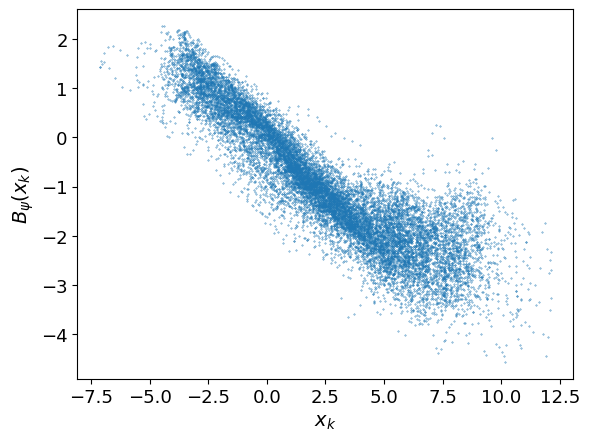

In [65]:
n_points = 15000
plt.scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label="ground truth")

plt.xlabel(r"$x_k$")
plt.ylabel(r"$B_{\psi}(x_k)$")

In [66]:
y_plot = correction_term.flatten()
x_plot = x.flatten()

mean, bin_edges, _ = binned_statistic(x_plot, y_plot, bins=10)
std, _, _ = binned_statistic(x_plot, y_plot, bins=10, statistic="std")
count, _, _ = binned_statistic(x_plot, y_plot, bins=10, statistic="count")

bin_centers = np.convolve(bin_edges, np.ones(2)/2, mode='valid')
sem = std / np.sqrt(count)

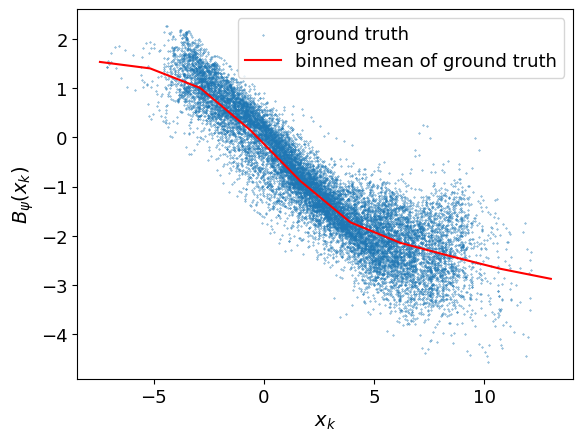

In [67]:
n_points = 15000
plt.scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label="ground truth")
plt.plot(bin_centers, mean, color="red", label="binned mean of ground truth")


plt.xlabel(r"$x_k$")
plt.ylabel(r"$B_{\psi}(x_k)$")
plt.legend()

In [86]:
path = "/gpfs/work/zinchenk/hpl_logs/parametrization_learning/multirun/2024-01-10/18-57-24/0/logs/checkpoints/simulator.ckpt"

In [87]:
simulator = torch.load(path, map_location=device)
parametrization = simulator.parametrization

In [88]:
# x_in = torch.linspace(bin_centers[0], bin_centers[-1], 100).unsqueeze(0).unsqueeze(0)
simulator = torch.load(path, map_location=device)
parametrization = simulator.parametrization
x_in = torch.tensor(bin_centers).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.no_grad():
    b_out = parametrization.forward(x_in)

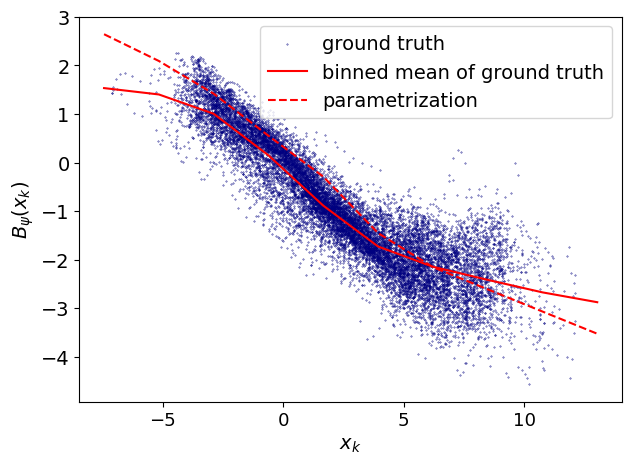

In [89]:
n_points = 15000
fig = plt.figure(figsize=(7, 5), facecolor="white")
plt.scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label="ground truth", color="navy")
plt.plot(bin_centers, mean, color="red", label="binned mean of ground truth")
plt.plot(x_in.squeeze().detach().to("cpu").numpy(), b_out.squeeze().detach().to("cpu").numpy(), color="red", ls="--", label="parametrization")


plt.yticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r"$x_k$", fontsize=14)
plt.ylabel(r"$B_{\psi}(x_k)$", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("input_output_function.png", dpi=300)

In [90]:
x.shape

torch.Size([36000, 36])

In [39]:
simtrue = x[0:600, :]
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
ax.pcolor(simtrue.T)
time_ticks = np.arange(0, 601, 100)
ax.set_xticks(time_ticks, time_ticks*0.01)
ax.set_yticks([])
plt.savefig("simulator_true.png", dpi=300)

NameError: name 'x' is not defined

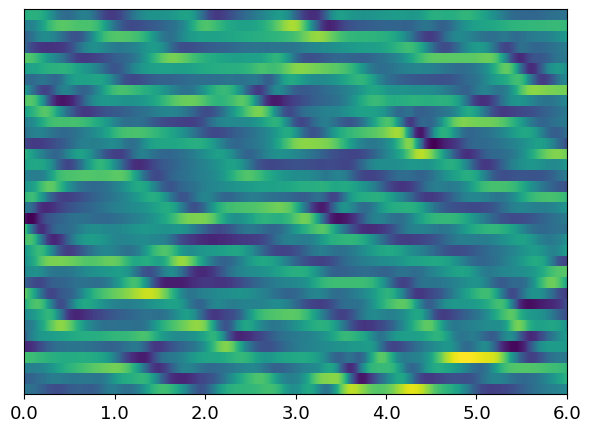

In [92]:
simulator_one = L96Simulator(forcing=8)
x_input = x[0, :].unsqueeze(0).unsqueeze(0).to(device)
time = torch.arange(0, 600*0.01, 0.01).to(device)
simone = simulator_one.integrate(time, x_input).squeeze().to("cpu")
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
plt.pcolor(simone.T)
time_ticks = np.arange(0, 601, 100)
ax.set_xticks(time_ticks, time_ticks*0.01)
ax.set_yticks([])
plt.savefig("simulator_one.png", dpi=300)

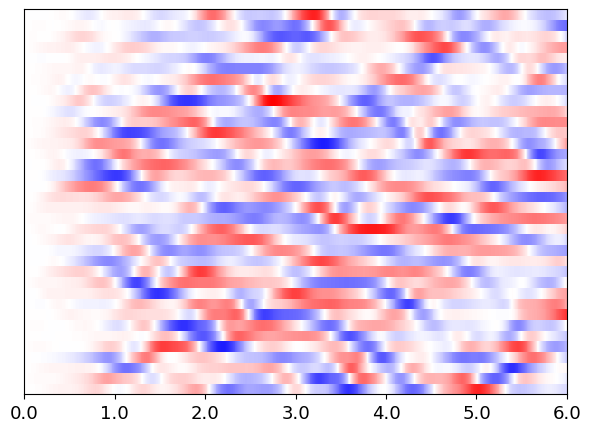

In [98]:
diff_one = simtrue.to("cpu") - simone.to("cpu")
diff_par = simtrue.to("cpu") - simpar.to("cpu")
limit = torch.stack([diff_one.abs(), diff_par.abs()]).max()

fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
ax.pcolor(diff_one.T, cmap="bwr", vmin=-limit, vmax=limit)
time_ticks = np.arange(0, 601, 100)
ax.set_xticks(time_ticks, time_ticks*0.01)
ax.set_yticks([])
plt.savefig("diff_one.png", dpi=300)


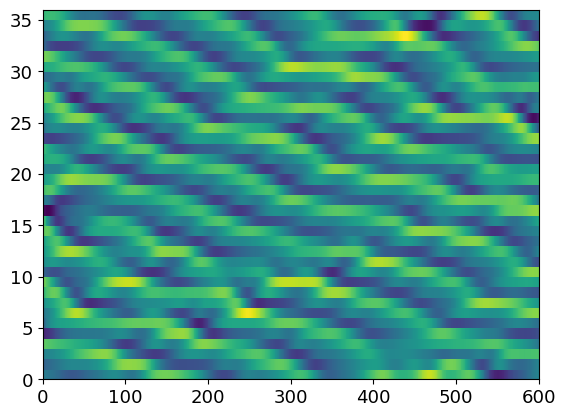

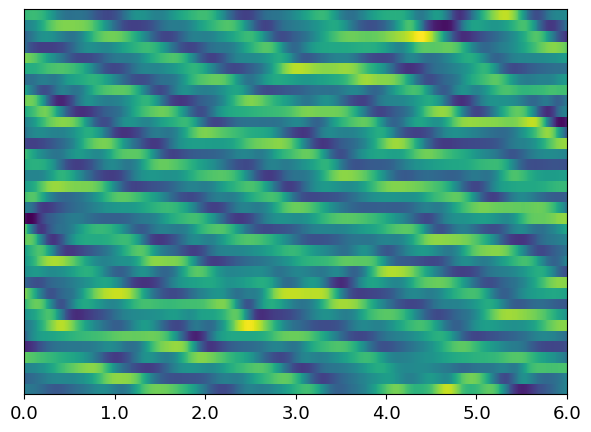

In [94]:
simpar = simulator.integrate(time, x_input).squeeze().detach()
plt.pcolor(simpar.to("cpu").T)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
plt.pcolor(simpar.to("cpu").T)
time_ticks = np.arange(0, 601, 100)
ax.set_xticks(time_ticks, time_ticks*0.01)
ax.set_yticks([])
plt.savefig("simulator_par.png", dpi=300)

In [ ]:
time_ticks = np.arange(0, 601, 100)

NameError: name 'simtrue' is not defined

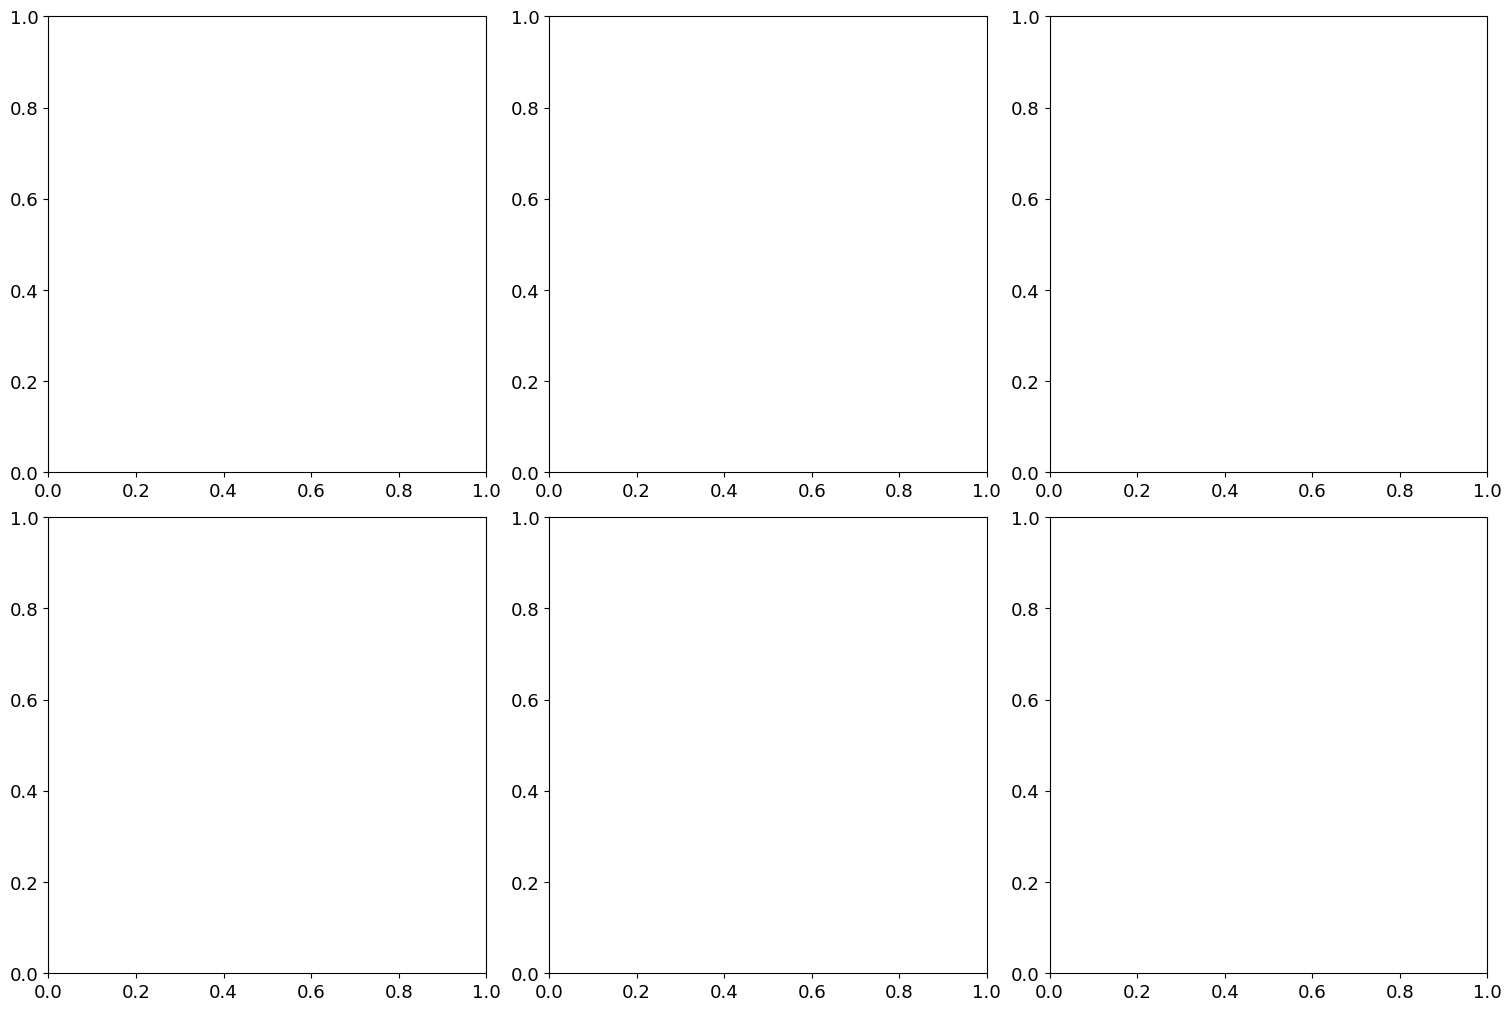

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), facecolor="white", constrained_layout=True)


limit = torch.stack([simtrue.to("cpu").abs(), simone.to("cpu").abs(), simpar.to("cpu").abs()]).max()
img0 = axes[0, 0].pcolor(simtrue.to("cpu").T, vmin=-limit, vmax=limit)
img1 = axes[0, 1].pcolor(simpar.to("cpu").T, vmin=-limit, vmax=limit)
img2 = axes[0, 2].pcolor(simone.to("cpu").T, vmin=-limit, vmax=limit)

diff = simtrue.to("cpu") - simone.to("cpu")
limit = torch.abs(diff).max()
img3 = axes[1, 0].scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label="ground truth", color="navy")
img4 = axes[1, 0].plot(bin_centers, mean, color="red", label="binned mean of ground truth")
img5 = axes[1, 0].plot(x_in.squeeze().detach().to("cpu").numpy(), b_out.squeeze().detach().to("cpu").numpy(), color="red", ls=":", label="parametrization")
axes[1, 0].legend()

img6 = axes[1, 1].pcolor((simtrue.to("cpu") - simpar.to("cpu")).T, cmap="bwr", vmin=-limit, vmax=limit)
img7 = axes[1, 2].pcolor((simtrue.to("cpu") - simone.to("cpu")).T, cmap="bwr", vmin=-limit, vmax=limit)


# plt.savefig("simulator_comparison.png", dpi=300)

axes[0, 0].set_yticks([])
axes[0, 1].set_yticks([])
axes[0, 2].set_yticks([])
axes[1, 1].set_yticks([])
axes[1, 2].set_yticks([])
axes[0, 0].set_xticks(time_ticks, time_ticks*0.01)
axes[0, 1].set_xticks(time_ticks, time_ticks*0.01)
axes[0, 2].set_xticks(time_ticks, time_ticks*0.01)
axes[1, 1].set_xticks(time_ticks, time_ticks*0.01)
axes[1, 2].set_xticks(time_ticks, time_ticks*0.01)

axes[0, 0].set_ylabel("state")
axes[1, 1].set_ylabel("difference")

axes[1, 0].set_xlabel(r"$x_k$")
axes[1, 0].set_ylabel(r"$\mathcal{B}_{\psi}(x_k)$")

axes[0, 0].set_title("Two-levels")
axes[0, 1].set_title("Parametrized by network")
axes[0, 2].set_title("One-level")
axes[1, 1].set_xlabel("time")
axes[1, 2].set_xlabel("time")

axes[1, 0].set_title("input-output function")
axes[1, 1].set_title("Two-levels vs Parametrized")
axes[1, 2].set_title("Two-levels vs One-level")


labels = ["A.", "B.", "C.", "D.", "E.", "F."]
for i, ax in enumerate(axes.flatten()):
    ax.set_title(labels[i], loc='left', fontsize=BIGGER_SIZE)

fig.colorbar(img2, ax=axes[0, :])
fig.colorbar(img7, ax=axes[1, :])
plt.savefig("parametrization.png", bbox_inches='tight')